In [114]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Energy Look-Up Table

**Authors:** Michele Peresano & Karl Kosack

**Datasample:** 

- gamma-1 for training (goes into energy training)
- gamma-2 for testing (goes into classification training because we use estimated energy as one of the features)

**NOTE:** this could be technically merged into the "to_energy-estimation" notebook, since it uses the same (training) data, but it's also a nice check on its own.

**Data level:** DL1b + DL2a (telescope-wise image parameters + shower geometry information)

**Scope:**

An alternative to more complex machine learning approaches, this LUT allows to estimate the energy of a
test event by assigning an average value based on true energy of a training event with some of its reconstructed image parameters and shower geometry.

It can also been used as a benchmark: at a fixed true energy we expect that intensity of the image drops down with increasing impact parameter.

**Approach:**

- given intensity and impact parameter of every image/shower pair, build a LUT using true energy as a weight

## Table of contents
  - [LUT from training sample](#LUT-from-training-sample)
  - [Use these LUTs to predict the reconstructed energy](#Use-these-LUTs-to-predict-the-reconstructed-energy)
      - [Re-apply them first to the train sample](#Re-apply-them-first-to-the-train-sample)
      - [Predict the reconstructed energy of the test sample](#Predict-the-reconstructed-energy-of-the-test-sample)

## Imports

In [115]:
import os
from pathlib import Path
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.interpolate import RectBivariateSpline
import tables
import pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Functions

In [116]:
def get_camera_names(inputPath = None, fileName = None):
    """Read the names of the cameras.
    
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    camera_names : list(str)
        Table names as a list.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    h5file = tables.open_file(os.path.join(inputPath, fileName), mode='r')
    group = h5file.get_node("/")
    camera_names = [x.name for x in group._f_list_nodes()]
    h5file.close()
    return camera_names

In [117]:
def load_reset_infile_protopipe(inputPath = None, fileName = None, camera_names=None):
    """(Re)load the file containing DL1(a) data and extract the data per telescope type.
     
    Parameters
    ==========
    infile : str
        Full path of the input DL1 file.
    fileName : str
        Name of the input DL1 file.
    
    Returns
    =======
    dataFrames : dict(pandas.DataFrame)
        Dictionary of tables per camera.
    """
    if (inputPath is None) or (fileName is None):
        print("ERROR: check input")
    if camera_names is None:
        print("ERROR: no cameras specified")
    # load DL1 images
    dataFrames = {camera : pandas.read_hdf(os.path.join(inputPath, fileName), f"/{camera}") for camera in camera_names}
    return dataFrames

In [118]:
def create_lookup_function(binned_stat):
    """
    Returns a function f(x,y) that evaluates the lookup at a point.
    """
    cx = 0.5 * (binned_stat.x_edge[0:-1] + binned_stat.x_edge[1:])
    cy = 0.5 * (binned_stat.y_edge[0:-1] + binned_stat.y_edge[1:])
    z = binned_stat.statistic
    z[~np.isfinite(z)] = 0  # make sure there are no infs or nans
    interpolator = RectBivariateSpline(x=cx, y=cy, z=z, kx=1, ky=1, s=0)
    return lambda x,y : interpolator.ev(x,y) # go back to TeV and evaluate

## Input data

In [119]:
# EDIT ONLY THIS CELL
analyses_dir = Path("/Users/michele/Applications/ctasoft/dirac/") # parent directory of the 'shared_folder'
analysisName = "v0.4.0_dev1"

In [120]:
analysesPath = Path("shared_folder/analyses")
train_path = Path("data/TRAINING/for_energy_estimation")
test_path = Path("data/TRAINING/for_particle_classification")

In [121]:
indir_train = analyses_dir / analysesPath / analysisName / train_path
infile_train = "TRAINING_energy_tail_gamma_merged.h5"

In [122]:
indir_test = analyses_dir / analysesPath / analysisName / test_path
infile_test = "TRAINING_classification_tail_gamma_merged.h5"

In [123]:
cameras = get_camera_names(inputPath = indir_train,
                                   fileName = infile_train)
data_train = load_reset_infile_protopipe(inputPath = indir_train,
                                   fileName = infile_train,
                                   camera_names=cameras)

In [124]:
intensity = {}
impact_distance = {}
true_energy = {}

In [125]:
# select only successfully reconstructed showers from good images
valid_showers_train = {}
for camera in cameras:
    valid_showers_train[camera] = data_train[camera][(data_train[camera]["is_valid"]==True) 
                                                     & (data_train[camera]["good_image"]==1)]

In [126]:
for camera in cameras:
    
    intensity[camera] = valid_showers_train[camera]["hillas_intensity_reco"]
    impact_distance[camera] = valid_showers_train[camera]["impact_dist"]
    true_energy[camera] = valid_showers_train[camera]["true_energy"]

## LUT from training sample
[back to top](#Table-of-contents)

Few things to notice for interpreting these LUTs:

- for a fixed intensity, the energy should increase with impact distance because far away showers are fainter,
- any tail in the low-intensity-high-impact regime is (at least) a sign of mis-reconstruction of the shower geometry,
- in the high-intensity-high-impact regime there should be no data, since it's too below the intensity threshold to be triggered

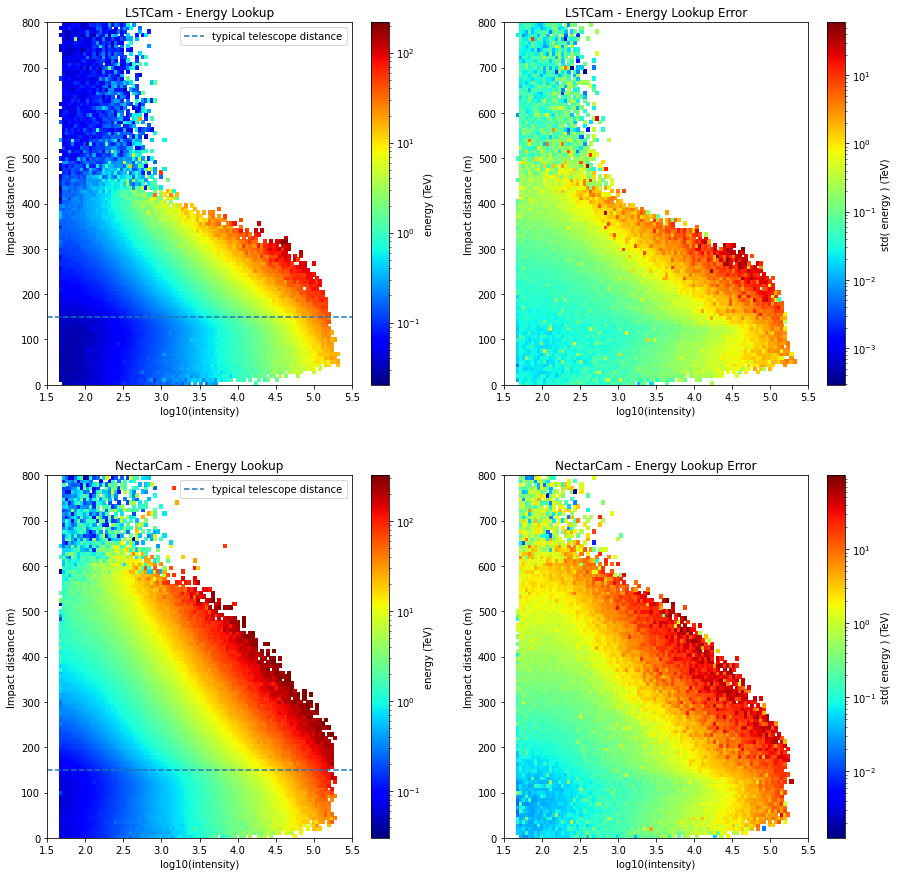

In [127]:
fig = plt.figure(figsize=(15, 15))

plt.subplots_adjust(hspace=0.25)

hist_geom = dict(bins=[100, 100],
                 range=[[1.5, 5.5],  # log10(intensity)
                        [0.0, 800]]) # impact distance
energy_LUT = {}
energy_LUT_errors = {}

for i, camera in enumerate(cameras):
    
    plt.subplot(2, 2, i*2 + 1)

    energy_LUT[camera] = binned_statistic_2d(
        x=np.log10(intensity[camera]),
        y=impact_distance[camera],
        values=true_energy[camera],
        statistic="mean",
        **hist_geom
    )
        
    plt.pcolormesh(
        energy_LUT[camera].x_edge,
        energy_LUT[camera].y_edge,
        energy_LUT[camera].statistic.T,
        norm=LogNorm(),
        cmap="jet",
        )
    plt.title(f"{camera} - Energy Lookup")
    plt.ylabel("Impact distance (m)")
    plt.xlabel("log10(intensity)")
    plt.colorbar(label="energy (TeV)")
    plt.axhline(150, ls='--', label="typical telescope distance")
    plt.legend()
        
    plt.subplot(2, 2, i*2 + 2)

    energy_LUT_errors[camera] = binned_statistic_2d(
        x=np.log10(intensity[camera]),
        y=impact_distance[camera],
        values=true_energy[camera],
        statistic="std",
        **hist_geom
    )
        
    plt.pcolormesh(
        energy_LUT_errors[camera].x_edge,
        energy_LUT_errors[camera].y_edge,
        energy_LUT_errors[camera].statistic.T,
        norm=LogNorm(),
        cmap="jet",
        )
    plt.title(f"{camera} - Energy Lookup Error")
    plt.ylabel("Impact distance (m)")
    plt.xlabel("log10(intensity)")
    plt.colorbar(label="std( energy ) (TeV)")

## Use these LUTs to predict the reconstructed energy
[back to top](#Table-of-contents)

We should expect that the migration matrix and it's benchmark energy resolution and bias are less then or at least similar to what we get from the ML model.

In [128]:
# Get an energy estimator for each camera

energy_estimator = {}

for camera in cameras:
    
    energy_estimator[camera] = create_lookup_function(energy_LUT[camera])

### Re-apply them first to the train sample
[back to top](#Table-of-contents)

The difference between the energy reconstructed with the LUT and the originally binned data should be mostly 0, apart where the error is very high or where relevant DL1 parameters are undefined (but we cut those here).

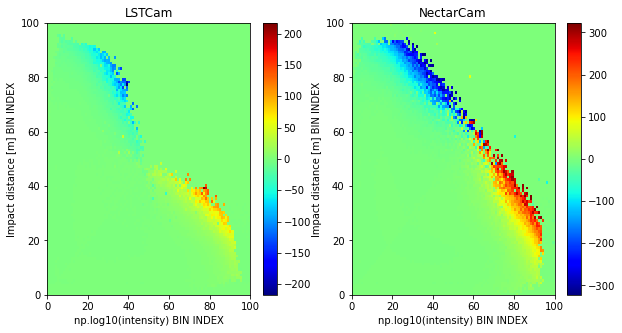

In [129]:
plt.figure(figsize=(10, 5))

for i, camera in enumerate(cameras):
    
    plt.subplot(1, 2, i+1)

    cx = 0.5*(energy_LUT[camera].x_edge[0:-1] +  energy_LUT[camera].x_edge[1:])
    cy = 0.5*(energy_LUT[camera].y_edge[0:-1] +  energy_LUT[camera].y_edge[1:])
    mx, my = np.meshgrid(cx,cy)
    reco_energy = energy_estimator[camera](mx,my)
    plt.pcolormesh(reco_energy - energy_LUT[camera].statistic, cmap='jet')
    plt.colorbar()
    plt.title(camera)
    plt.xlabel("np.log10(intensity) BIN INDEX")
    plt.ylabel("Impact distance [m] BIN INDEX")

### Predict the reconstructed energy of the test sample
[back to top](#Table-of-contents)

To be compared with the plots from the DL2 "to classification" notebook

In [130]:
data_test = load_reset_infile_protopipe(inputPath = indir_test,
                                   fileName = infile_test,
                                   camera_names=cameras)

In [131]:
# we select also in this case only events which passed the cuts in the pipeline
# select only successfully reconstructed showers from good images
valid_showers_test = {}
for camera in cameras:
    valid_showers_test[camera] = data_test[camera][(data_test[camera]["is_valid"]==True) 
                                                     & (data_test[camera]["good_image"]==1)].copy()

In [132]:
for camera in cameras:

    valid_showers_test[camera]["reco_energy_LUT"] = energy_estimator[camera](np.log10(valid_showers_test[camera]["hillas_intensity_reco"]),
                                                                             valid_showers_test[camera]["impact_dist"])

/Users/michele/Applications/miniconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


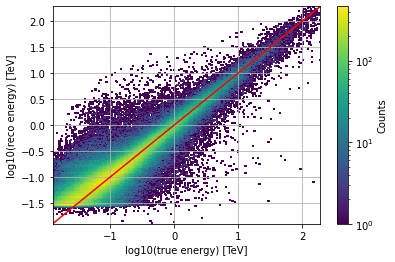

In [133]:
# merge the tables from test data
for i, camera in enumerate(cameras):
    if i==0:
        all_valid_showers_test = valid_showers_test[camera]
    else:
        all_valid_showers_test = all_valid_showers_test.append(valid_showers_test[camera])
# Finally drop duplicate showers (stereo information is the same for each event ID)
unique_all_valid_showers_test = all_valid_showers_test.drop_duplicates(subset=['event_id'])

x = np.log10(unique_all_valid_showers_test["true_energy"].values)
y = np.log10(unique_all_valid_showers_test["reco_energy_LUT"].values)

bin_edges = np.arange(-1.9, 2.3, 1/50)

plt.hist2d(x, y, bins=[bin_edges, bin_edges], norm=LogNorm())
plt.grid(which="both", axis="both")
plt.colorbar(label='Counts')
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('log10(reco energy) [TeV]')

plt.plot(bin_edges, bin_edges, color="red")

None # to remove clutter by mpl objects

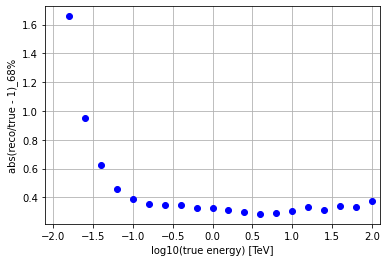

In [134]:
reco = unique_all_valid_showers_test["reco_energy_LUT"].values
true = unique_all_valid_showers_test["true_energy"].values

def resolution(x):
    return np.percentile(x, 68)

bin_edges_x = np.arange(-1.9, 2.3, 1/5)
h = binned_statistic(np.log10(true), np.abs(reco/true - 1), statistic=resolution, bins=bin_edges_x)

plt.plot(0.5 * (h[1][:-1] + h[1][1:]), h[0], "bo")

plt.grid(which="both", axis="both")
plt.xlabel('log10(true energy) [TeV]')
plt.ylabel('abs(reco/true - 1)_68%')
plt.xlim(-2.1, 2.1)

None # to remove clutter by mpl objects